https://eli5.readthedocs.io/en/latest/_modules/eli5/sklearn/explain_weights.html
https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#explaining-predictions

Also take a look at https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html.

In [1]:
!pip install shap
!pip install lime

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 273 kB 2.6 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-linux_x86_64.whl size=399307 sha256=06a339fdb1eb0956b3ad3138f09d30716a8605e06e764d24d9e233abce6d1a3c
  Stored in directory: /home/jovyan/.cache/pip/wheels/c3/e0/82/26cebc699e23c6a1b9963981e1a10ed7de75db012f4af12428
Successfully built shap
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 275 kB 2.3 MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283844 sha256=fd172663a3252479d43cb6fcc5b51dec2d5b800c23cb9a3378353322f8e05f52
  Stored in directory: /home/jovyan/.cache/pip/w

In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# import dabl
import shap
import lime
import lime.lime_tabular
sns.set_style('ticks')

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from utils import evaluate_classifier, get_sklearn_df 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Crop types to be used for explainability
explainability_crop_types = {
    'Potato': True,
    'Spring barley': False,
    'Winter barley': False,
    'Spring wheat': True,
    'Winter wheat': True,
    'Winter rye': False,
    'Spring oat': False,
    'Maize': False,
    'Rapeseed': True,
    'Permanent grass': False,
    'Willow': False,
    'Forest': True
}

# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [5]:
netcdf_path = (PROJ_PATH / 'internship'/'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 389 ms


In [6]:
ds.close()

time: 76 ms


In [8]:
df_sklearn = get_sklearn_df(polygons_year=2019, 
                            satellite_dates=slice('2019-03-01', '2019-09-01'), 
                            fields='all', 
                            satellite='S1A', 
                            polarization='all',
                            crop_type='all',
                            netcdf_path=netcdf_path)
    
df_sklearn_remapped = df_sklearn.copy()
df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1

for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value
print(f"Crop types: {class_names}")

# Drop the columns not ud for explainability
for key, value in explainability_crop_types.items():
    if not value:
        df_sklearn_remapped = df_sklearn_remapped[df_sklearn_remapped['Crop type'] != key]
print(f"Crop types used for explainability:  {df_sklearn_remapped['Crop type'].unique()}")
class_names = df_sklearn_remapped['Crop type'].unique()

# Re-arrange columns 
cols_rearranged = list(df_sklearn_remapped.columns[:5]) + list(sorted(df_sklearn_remapped.columns[5:]))
df_sklearn_remapped = df_sklearn_remapped[cols_rearranged]

# Keep every n'th date (hardcoded to use VV and VH polarizations!!)
n = 6 
num_cols = len(df_sklearn_remapped.columns)
keep_cols_index = [0, 1, 2, 3, 4] + list(range(5, num_cols, n+1)) + list(range(6, num_cols, n+1))  # meta-data + VV polarizations + VH polarizations
print(keep_cols_index)
df_sklearn_remapped = df_sklearn_remapped.iloc[:, keep_cols_index]

# Re-arrange columns 
cols_rearranged = list(df_sklearn_remapped.columns[:5]) + list(sorted(df_sklearn_remapped.columns[5:]))
df_sklearn_remapped = df_sklearn_remapped[cols_rearranged]

# Get values as numpy array
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

Crop types: ['Potato', 'Spring barley', 'Winter barley', 'Spring wheat', 'Winter wheat', 'Winter rye', 'Spring oat', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow', 'Forest']
Crop types used for explainability:  ['Potato' 'Spring wheat' 'Winter wheat' 'Rapeseed' 'Forest']
[0, 1, 2, 3, 4, 5, 12, 19, 26, 33, 40, 47, 6, 13, 20, 27, 34, 41, 48]
time: 11.1 s


In [9]:
df_plot = df_sklearn_remapped.drop(['field_id', 'afgkode', 'afgroede', 'Label ID'], axis=1)
df_plot

Crop type  2019-03-11_VH  2019-03-11_VV  2019-04-04_VV  \
0        Potato     -24.684210      -9.868421     -10.844961   
1        Potato     -23.090014     -12.728551     -11.614084   
2        Potato     -24.424000     -14.600000     -13.248000   
3        Potato     -25.014769     -14.468354     -12.734736   
4        Potato     -24.732241     -14.746449     -12.707423   
...         ...            ...            ...            ...   
44402    Forest     -21.886486     -11.616217     -10.351648   
44403    Forest     -22.333334     -11.950000     -11.787709   
44404    Forest     -14.012500      -8.862500      -7.797619   
44405    Forest     -16.335821     -10.649254      -8.551471   
44406    Forest     -17.191111     -10.973333      -9.495575   

       2019-04-04_VV-VH  2019-04-28_VV-VH  2019-05-10_VH  2019-06-03_VH  \
0             13.139535         10.983193     -17.322834     -20.207693   
1              9.936620          8.489362     -18.990112     -17.146479   
2              7.032000         11.008000     -20.459677     -18.587301   
3              7.494737          8.253638     -21.434238     -17.075001   
4              6.783843          7.993450     -21.094875     -16.888889   
...                 ...               ...            ...            ...   
44402          8.362638          5.232432     -15.524064     -16.106741   
44403          5.000000          5.751381     -16.193371     -16.719101   
44404          4.476191          4.280488     -12.524390     -11.253012   
44405          4.220588          6.614815     -13.962963     -13.785714   
44406          4.137168          4.831859     -14.497778     -13.803572   

       2019-06-03_VV  2019-06-27_VV  2019-06-27_VV-VH  2019-07-21_VV-VH  \
0          -1.530769      -6.561984          9.355371          7.348214   
1         -11.333803      -8.884344          6.988717          6.522599   
2          -7.571429      -6.007936          8.269841          4.976000   
3         -10.179167      -9.135593          6.836864          6.629707   
4         -11.643791      -9.331161          7.064061          6.119126   
...              ...            ...               ...               ...   
44402     -11.191011     -11.725806          4.301075          3.837696   
44403     -11.516854     -11.687151          6.413408          4.692307   
44404      -5.927711      -7.132530          4.626506          5.337349   
44405      -8.192857      -7.828358          6.738806          5.105263   
44406      -8.500000      -8.862223          5.831111          5.651982   

       2019-08-02_VH  2019-08-26_VH  2019-08-26_VV  
0         -14.508333     -13.897058      -7.470588  
1         -14.327248     -14.075070      -7.277620  
2         -13.873015     -13.112000      -7.408000  
3         -14.449580     -14.546025      -7.504184  
4         -14.532751     -14.142082      -7.244035  
...              ...            ...            ...  
44402     -15.920213     -16.237839     -10.740541  
44403     -15.630435     -16.145947     -10.529730  
44404     -12.629630     -12.190476      -7.988095  
44405     -14.350746     -14.424460      -8.402878  
44406     -15.079646     -15.471366      -8.925110  

[17870 rows x 15 columns]

time: 117 ms


In [10]:
df_plot['Crop type'].value_counts()

Potato          7508
Rapeseed        3738
Winter wheat    3716
Spring wheat    1608
Forest          1300
Name: Crop type, dtype: int64

time: 90.6 ms


In [11]:
df_plot_balanced = pd.DataFrame(columns=df_plot.columns)
for crop_type in class_names:
    df_plot_balanced = pd.concat([df_plot_balanced, df_plot[df_plot['Crop type'] == crop_type].sample(100)])
df_plot_balanced['Crop type'].value_counts()

Forest          100
Potato          100
Spring wheat    100
Winter wheat    100
Rapeseed        100
Name: Crop type, dtype: int64

time: 115 ms


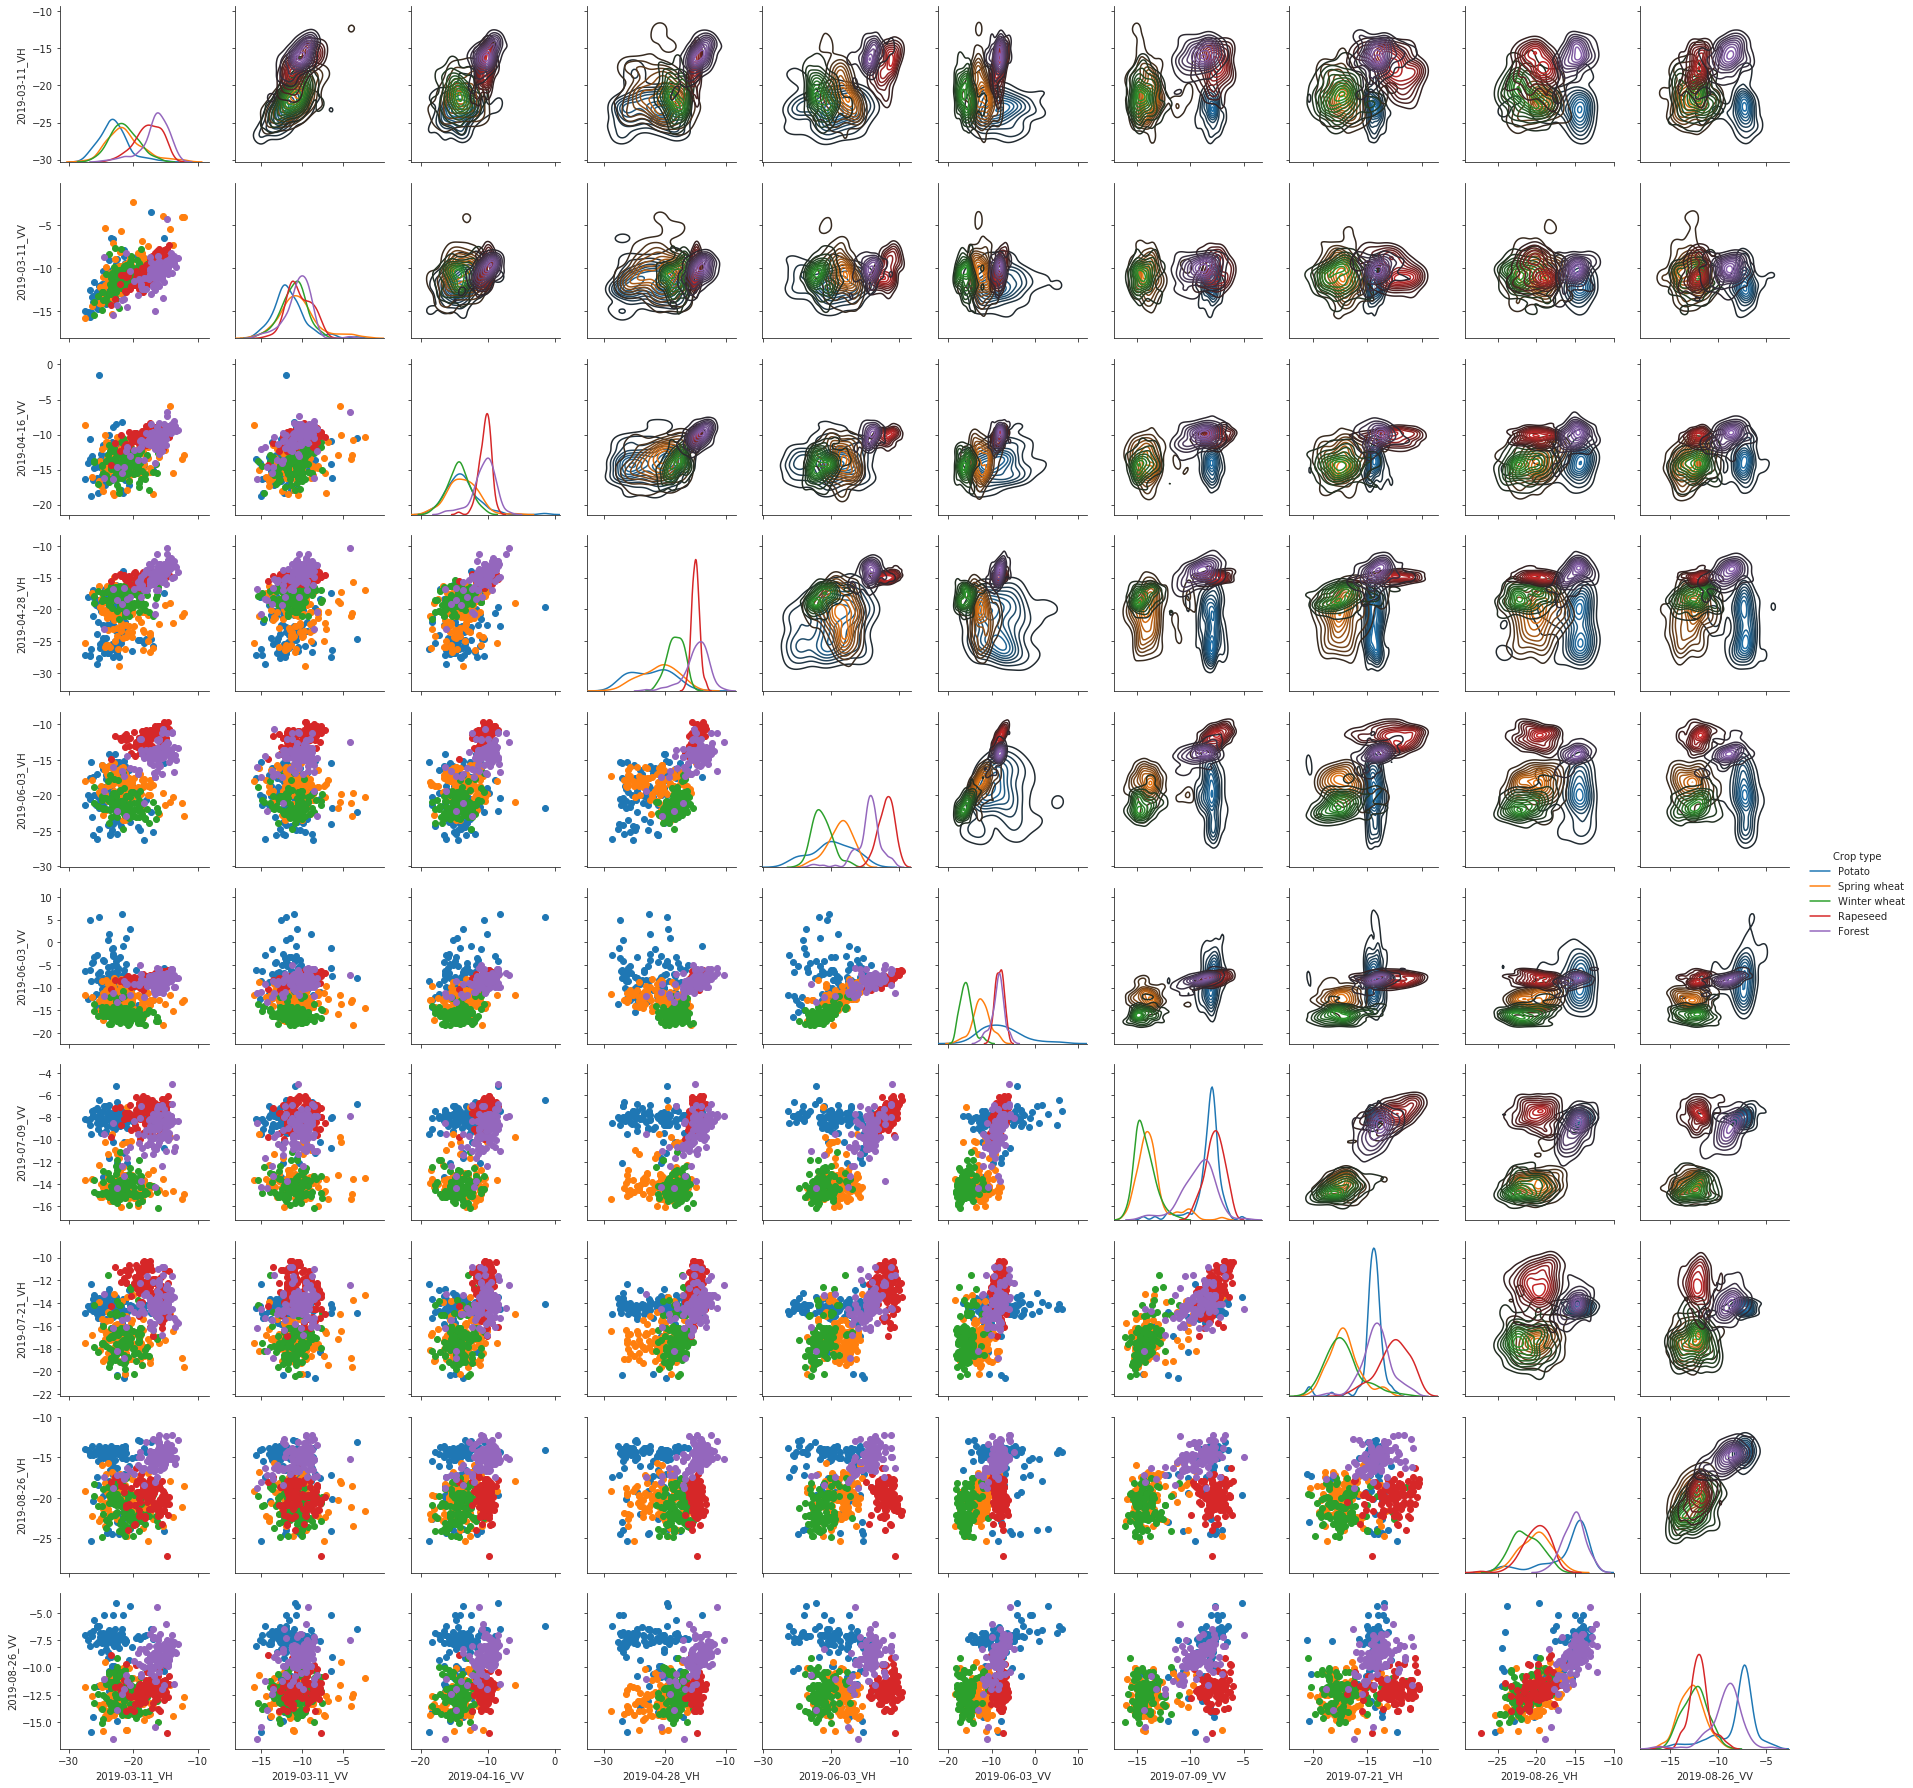

time: 2min 35s


In [164]:
g = sns.PairGrid(df_plot_balanced, hue='Crop type')
g.map_diag(sns.kdeplot)
g.map_lower(plt.scatter)
g.map_upper(sns.kdeplot)
g.add_legend()

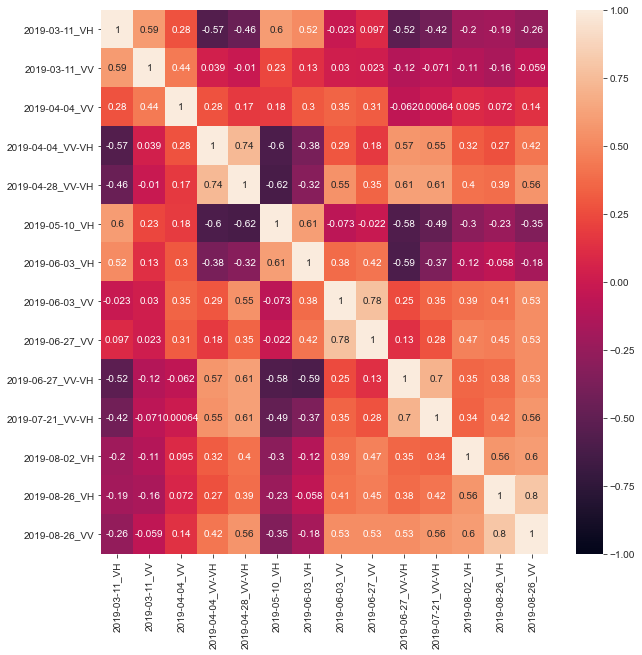

time: 1.63 s


In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_plot.corr(), annot=True, vmin=-1, vmax=1)

Training time: 13.4596 s
Prediction time: 0.011 s

Report:

Train accuracy: 0.9567
Test accuracy: 0.9571

               precision    recall  f1-score   support

      Potato       0.98      0.99      0.98      2242
Spring wheat       0.86      0.76      0.81       489
Winter wheat       0.92      0.97      0.94      1158
    Rapeseed       0.99      0.99      0.99      1104
      Forest       0.96      0.91      0.93       368

    accuracy                           0.96      5361
   macro avg       0.94      0.92      0.93      5361
weighted avg       0.96      0.96      0.96      5361



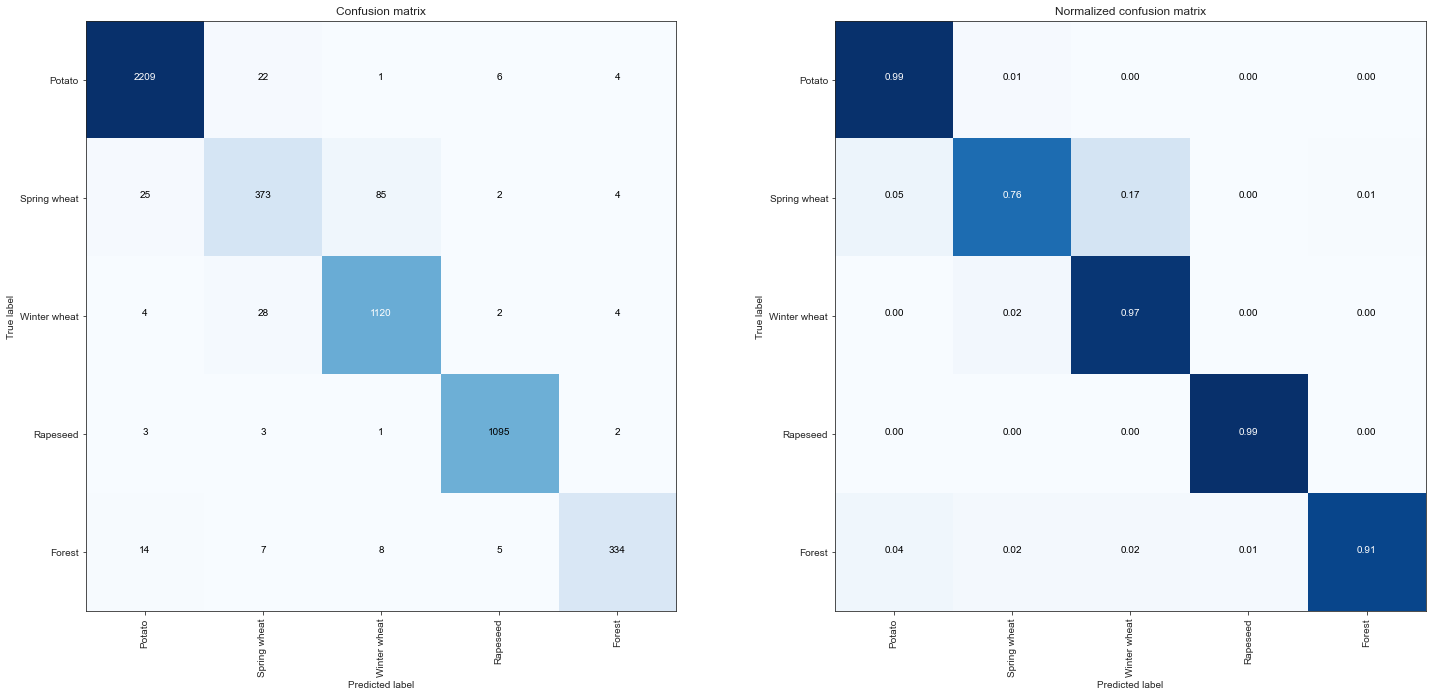

time: 14.3 s


In [13]:
# Instantiate and evaluate classifier
from sklearn.linear_model import LogisticRegression          
clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000)
clf_trained, _, accuracy_test, results_report, conf_matrix = evaluate_classifier(
    clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False, plot_conf_matrix=True,
    print_classification_report=True)

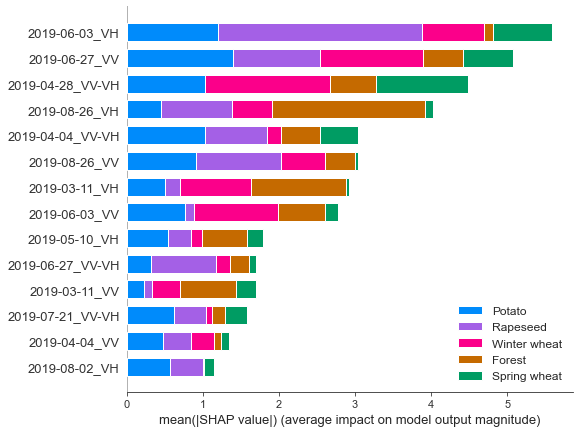

time: 684 ms


In [14]:
# https://slundberg.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html
shap.initjs()
logistic_regression_explainer = shap.LinearExplainer(clf_trained, X_test, feature_perturbation='interventional')
logistic_regression_shap_values = logistic_regression_explainer.shap_values(X_test)
shap.summary_plot(logistic_regression_shap_values, X_test, feature_names=df_plot.columns[1:], class_names=class_names)

In [15]:
print(y_test[0:20])

[ 0  0  3  4  4  0  0  0  4  4  0  0  3 11  4  0  3  8  3  8]
time: 81.1 ms


In [16]:
sample_number = 5
num_features = len(df_plot.columns[1:])
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df_plot.columns[1:], class_names=class_names, discretize_continuous=False)
explanation = explainer.explain_instance(X_test[sample_number], clf_trained.predict_proba, num_features=num_features, top_labels=1)
print(f"True label: {list(mapping_dict.keys())[y_test[sample_number]]}")  # Slightly hacky way to get the correct crop type
explanation.show_in_notebook(show_table=True, show_all=True)

True label: Potato


time: 250 ms
